# DPU example: YOLOv3 & Webcam
----

## Aim/s
* This notebooks shows an example of DPU applications using webcam. The application,as well as the DPU IP, is pulled from the official 
[Vitis AI Github Repository](https://github.com/Xilinx/Vitis-AI).

## References
* [Vitis AI Github Repository](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html).

## Last revised
* May 31, 2023
    * Initial revision
----

## 1. Prepare the overlay
We will download the overlay onto the board. 

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 98.8879MHz.
  warnings.warn(


## 2. Utility functions

In this section, we will prepare a few functions for later use.

In [2]:
import os
import time
import numpy as np
import cv2
import random
import colorsys
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
%matplotlib inline

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

**Note** For the KV260 board you may see TLS memory allocation errors if cv2 gets loaded before loading the vitis libraries in the Jupyter Lab environment. Make sure to load cv2 first in these cases.

In [3]:
overlay.load_model("./xmodel/tf_yolov3_voc.xmodel")

Let's first define a few useful preprocessing functions.

In [4]:
anchor_list = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]
anchor_float = [float(x) for x in anchor_list]
anchors = np.array(anchor_float).reshape(-1, 2)

In [5]:
'''Get model classification information'''	
def get_class(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names
    
classes_path = "img/voc_classes.txt"
class_names = get_class(classes_path)
num_classes = len(class_names)

In [6]:
hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: 
                  (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), 
                  colors))
random.seed(0)
random.shuffle(colors)
random.seed(None)

In [7]:
'''resize image with unchanged aspect ratio using padding'''
def letterbox_image(image, size):
    ih, iw, _ = image.shape
    w, h = size
    scale = min(w/iw, h/ih)
    #print(scale)
    
    nw = int(iw*scale)
    nh = int(ih*scale)
    #print(nw)
    #print(nh)

    image = cv2.resize(image, (nw,nh), interpolation=cv2.INTER_LINEAR)
    new_image = np.ones((h,w,3), np.uint8) * 128
    h_start = (h-nh)//2
    w_start = (w-nw)//2
    new_image[h_start:h_start+nh, w_start:w_start+nw, :] = image
    return new_image


'''image preprocessing'''
def pre_process(image, model_image_size):
    image = image[...,::-1]
    image_h, image_w, _ = image.shape
 
    if model_image_size != (None, None):
        assert model_image_size[0]%32 == 0, 'Multiples of 32 required'
        assert model_image_size[1]%32 == 0, 'Multiples of 32 required'
        boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    else:
        new_image_size = (image_w - (image_w % 32), image_h - (image_h % 32))
        boxed_image = letterbox_image(image, new_image_size)
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)
    return image_data

We will also define a few functions to post-process the output after running a DPU task.

In [8]:
def _get_feats(feats, anchors, num_classes, input_shape):
    num_anchors = len(anchors)
    anchors_tensor = np.reshape(np.array(anchors, dtype=np.float32), [1, 1, 1, num_anchors, 2])
    grid_size = np.shape(feats)[1:3]
    nu = num_classes + 5
    predictions = np.reshape(feats, [-1, grid_size[0], grid_size[1], num_anchors, nu])
    grid_y = np.tile(np.reshape(np.arange(grid_size[0]), [-1, 1, 1, 1]), [1, grid_size[1], 1, 1])
    grid_x = np.tile(np.reshape(np.arange(grid_size[1]), [1, -1, 1, 1]), [grid_size[0], 1, 1, 1])
    grid = np.concatenate([grid_x, grid_y], axis = -1)
    grid = np.array(grid, dtype=np.float32)

    box_xy = (1/(1+np.exp(-predictions[..., :2])) + grid) / np.array(grid_size[::-1], dtype=np.float32)
    box_wh = np.exp(predictions[..., 2:4]) * anchors_tensor / np.array(input_shape[::-1], dtype=np.float32)
    box_confidence = 1/(1+np.exp(-predictions[..., 4:5]))
    box_class_probs = 1/(1+np.exp(-predictions[..., 5:]))
    return box_xy, box_wh, box_confidence, box_class_probs


def correct_boxes(box_xy, box_wh, input_shape, image_shape):
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = np.array(input_shape, dtype = np.float32)
    image_shape = np.array(image_shape, dtype = np.float32)
    new_shape = np.around(image_shape * np.min(input_shape / image_shape))
    offset = (input_shape - new_shape) / 2. / input_shape
    scale = input_shape / new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes = np.concatenate([
        box_mins[..., 0:1],
        box_mins[..., 1:2],
        box_maxes[..., 0:1],
        box_maxes[..., 1:2]
    ], axis = -1)
    boxes *= np.concatenate([image_shape, image_shape], axis = -1)
    return boxes


def boxes_and_scores(feats, anchors, classes_num, input_shape, image_shape):
    box_xy, box_wh, box_confidence, box_class_probs = _get_feats(feats, anchors, classes_num, input_shape)
    boxes = correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = np.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = np.reshape(box_scores, [-1, classes_num])
    return boxes, box_scores

In [9]:
'''Draw detection frame'''
def draw_bbox(image, boxes, scores, classes):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """
    num_classes = len(class_names)
    image_h, image_w, _ = image.shape

    for i, bbox in enumerate(boxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 1
        score = scores[i]
        class_ind = classes[i]
        bbox_color = tuple([color for color in colors[class_ind]])
        bbox_thick = int((image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)
        label = '{}: {:.4f}'.format(class_names[class_ind], score)
        cv2.putText(image,label,(c1[0]+5,c1[1]+25),cv2.FONT_HERSHEY_SIMPLEX,fontScale,bbox_color,2,cv2.LINE_AA)
    return image


def nms_boxes(boxes, scores):
    """Suppress non-maximal boxes.

    # Arguments
        boxes: ndarray, boxes of objects.
        scores: ndarray, scores of objects.

    # Returns
        keep: ndarray, index of effective boxes.
    """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2-x1+1)*(y2-y1+1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w1 = np.maximum(0.0, xx2 - xx1 + 1)
        h1 = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w1 * h1

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= 0.55)[0]  # threshold
        order = order[inds + 1]

    return keep

In [10]:
def evaluate(yolo_outputs, image_shape, class_names, anchors):
    score_thresh = 0.2
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    boxes = []
    box_scores = []
    input_shape = np.shape(yolo_outputs[0])[1 : 3]
    input_shape = np.array(input_shape)*32

    for i in range(len(yolo_outputs)):
        _boxes, _box_scores = boxes_and_scores(
            yolo_outputs[i], anchors[anchor_mask[i]], len(class_names), 
            input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = np.concatenate(boxes, axis = 0)
    box_scores = np.concatenate(box_scores, axis = 0)

    mask = box_scores >= score_thresh
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(len(class_names)):
        class_boxes_np = boxes[mask[:, c]]
        class_box_scores_np = box_scores[:, c]
        class_box_scores_np = class_box_scores_np[mask[:, c]]
        nms_index_np = nms_boxes(class_boxes_np, class_box_scores_np) 
        class_boxes_np = class_boxes_np[nms_index_np]
        class_box_scores_np = class_box_scores_np[nms_index_np]
        classes_np = np.ones_like(class_box_scores_np, dtype = np.int32) * c
        boxes_.append(class_boxes_np)
        scores_.append(class_box_scores_np)
        classes_.append(classes_np)
    boxes_ = np.concatenate(boxes_, axis = 0)
    scores_ = np.concatenate(scores_, axis = 0)
    classes_ = np.concatenate(classes_, axis = 0)

    return boxes_, scores_, classes_

Keep in mind that our original images are 640x480 so we need to preprocess them
later to make sure it fits our model.

In [11]:
image_folder = 'img'
original_images = sorted([i for i in os.listdir(image_folder) if i.endswith("JPEG")])
total_images = len(original_images)

## 3. Use VART
Now we should be able to use VART to do image classification.

In [12]:
dpu = overlay.runner

In [13]:
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)

shapeOut0 = (tuple(outputTensors[0].dims)) # (1, 13, 13, 75)
shapeOut1 = (tuple(outputTensors[1].dims)) # (1, 26, 26, 75)
shapeOut2 = (tuple(outputTensors[2].dims)) # (1, 52, 52, 75)

#outputSize0 = int(outputTensors[0].get_data_size() / shapeIn[0]) # 12675
#outputSize1 = int(outputTensors[1].get_data_size() / shapeIn[0]) # 50700
#outputSize2 = int(outputTensors[2].get_data_size() / shapeIn[0]) # 202800

We can define a few buffers to store input and output data. They will be reused
during multiple runs.

In [14]:
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
output_data = [np.empty(shapeOut0, dtype=np.float32, order="C"), 
               np.empty(shapeOut1, dtype=np.float32, order="C"),
               np.empty(shapeOut2, dtype=np.float32, order="C")]
image = input_data[0]

Remember that we have a list of `original_images`. 
We can now define a new function `run()` which takes the image index as 
the input, then decode and post-process the output as the detection result.
With the argument `display` set to `True`, the original image as well as the
detected objects and their labels can be rendered.

It is obvious that the range of `image_index` should be [0, `total_images`-1].

In [15]:
def dpu_process(input_image):
    # Pre-processing
    image_size = input_image.shape[:2]
    image_data = np.array(pre_process(input_image, (416, 416)), dtype=np.float32)
    
    # Fetch data to DPU and trigger it
    image[0,...] = image_data.reshape(shapeIn[1:])
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    # Retrieve output data
    conv_out0 = np.reshape(output_data[0], shapeOut0)
    conv_out1 = np.reshape(output_data[1], shapeOut1)
    conv_out2 = np.reshape(output_data[2], shapeOut2)
    yolo_outputs = [conv_out0, conv_out1, conv_out2]
    
    # Decode output from YOLOv3
    boxes, scores, classes = evaluate(yolo_outputs, image_size, class_names, anchors)
    
    output_image = draw_bbox(input_image, boxes, scores, classes)
    
    return output_image, classes

In [16]:
def run(image_index, display=False):
    # Read input image
    input_image = cv2.imread(os.path.join(image_folder, original_images[image_index]))
    
    output_image, classes = dpu_process(input_image)

    if display:
        _, ax = plt.subplots(1)
        _ = ax.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

    return output_image, classes

Let's run it for 1 image and print out the detected label.

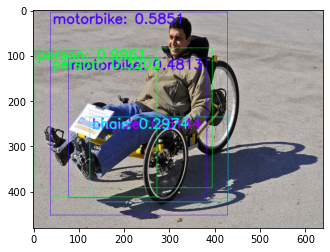

In [17]:
output_image, classes = run(3, display=True)

In [18]:
def runWebcam(device_index=0):
    try:
        cap = cv2.VideoCapture(device_index)
    except:
        print("Cannot Open Device.")
    try:
        ret, input_image = cap.read()
        
        while(ret==True):
            ret, input_image = cap.read()

            if not ret:
                cap.release()
                print ("Released Video Resource.")
                break

            output_image, classes = dpu_process(input_image) 

            # Display
            _,ret_array = cv2.imencode('.jpg', output_image) #this fixed the pipeline issue as the imshow was converting to png.
            i = display.Image(data=ret_array)
            display.display(i)
            display.clear_output(wait=True)

    except KeyboardInterrupt:
        print("Released Video Resource from KeyboardInterrupt.")
    finally:
        cap.release()

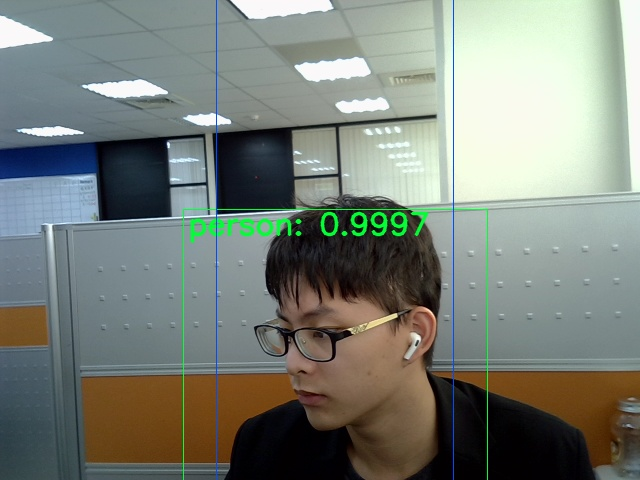

In [ ]:
runWebcam(0)

### It is recommended to stop webcam live like this.
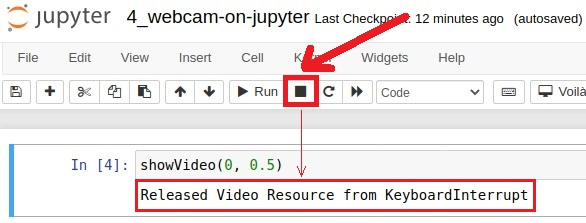

We will need to remove references to `vart.Runner` and let Python garbage-collect
the unused graph objects. This will make sure we can run other notebooks without
any issue.

In [ ]:
del overlay
del dpu

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----